In [8]:
import json, os, tldextract, re2, enchant, validators
from http.cookies import SimpleCookie
from urllib.parse import urlparse, parse_qs
from urllib.request import urlopen
from  collections import Counter, OrderedDict
from adblockparser import AdblockRules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import altair as alt

from utils.graphics import *


# 1. Loading and preparing data to analyze

In [9]:
ALL_SE_RESULTS = json.load(open('../Data/all_se_results.json'))
ALL_SE_NAMES = ["bing", "google", "ddg", "startpage", "qwant"]

### REMOVE USELESS FIELDS 
for list_ in ALL_SE_RESULTS:
    for search in list_:
        del search["results"]
        if "raw_body" in search:
            del search["raw_body"]
        
        
bing_results = ALL_SE_RESULTS[0]
google_results = ALL_SE_RESULTS[1]
ddg_results = ALL_SE_RESULTS[2]
startpage_results = ALL_SE_RESULTS[3]
qwant_results = ALL_SE_RESULTS[4]
   

# 2. Number of iterations where we received ads

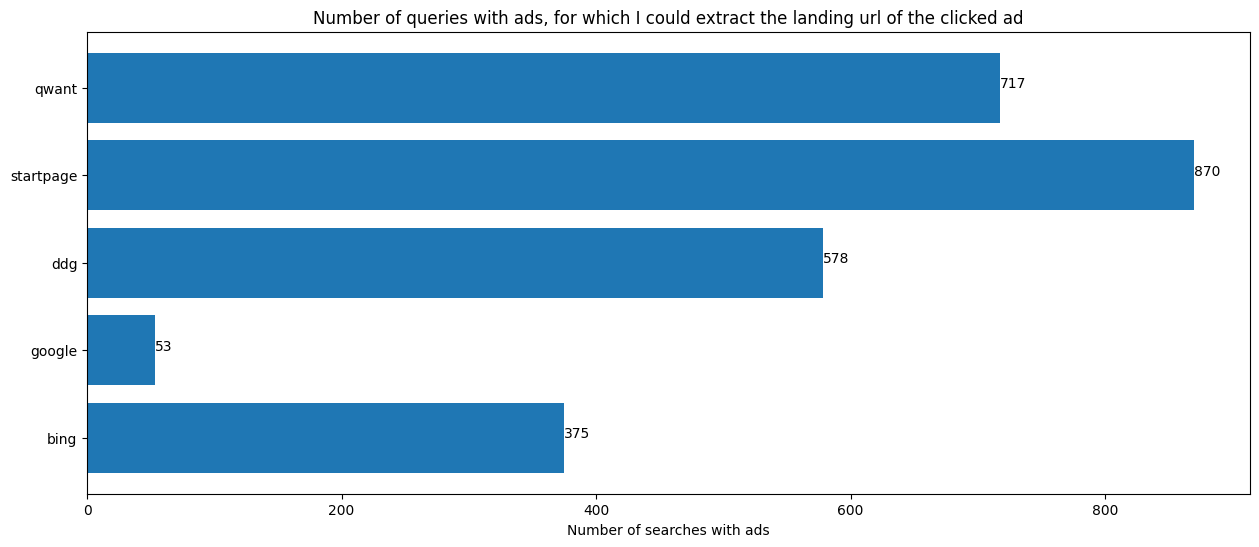

In [3]:
NB_WITH_ADS = []
for SE_RESULTS in ALL_SE_RESULTS:
    NB_WITH_ADS.append(len([item for item in SE_RESULTS if item["clicked_url"] != "" and len(item["ads"]) > 0 and "landing_url" in item["ads"][0] and item["ads"][0]["landing_url"] != ""]))

fig, ax = plt.subplots(figsize = (15,6))
ax.barh(ALL_SE_NAMES, NB_WITH_ADS)

for index, value in enumerate(NB_WITH_ADS):
    plt.text(value, index,
             str(value))

ax.set_xlabel('Number of searches with ads')
plt.title("Number of queries with ads, for which I could extract the landing url of the clicked ad")
 
    
    
plt.show()

### Keeping only queries where we have the ad destination landing url -- and max 500 per search engine

In [4]:
for index, list_ in enumerate(ALL_SE_RESULTS):
    list_ = [item for item in list_ if item["clicked_url"] != "" and len(item["ads"]) > 0 and "landing_url" in item["ads"][0] and item["ads"][0]["landing_url"] != ""]
    ALL_SE_RESULTS[index] = list_[:500]
    
    print("keeping for", ALL_SE_NAMES[index], len(ALL_SE_RESULTS[index]), "elements")
    

keeping for bing 375 elements
keeping for google 53 elements
keeping for ddg 500 elements
keeping for startpage 500 elements
keeping for qwant 500 elements


# 3. BEFORE CLICKING ON ADS

### Number of requests to trackers before clicking on ads

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


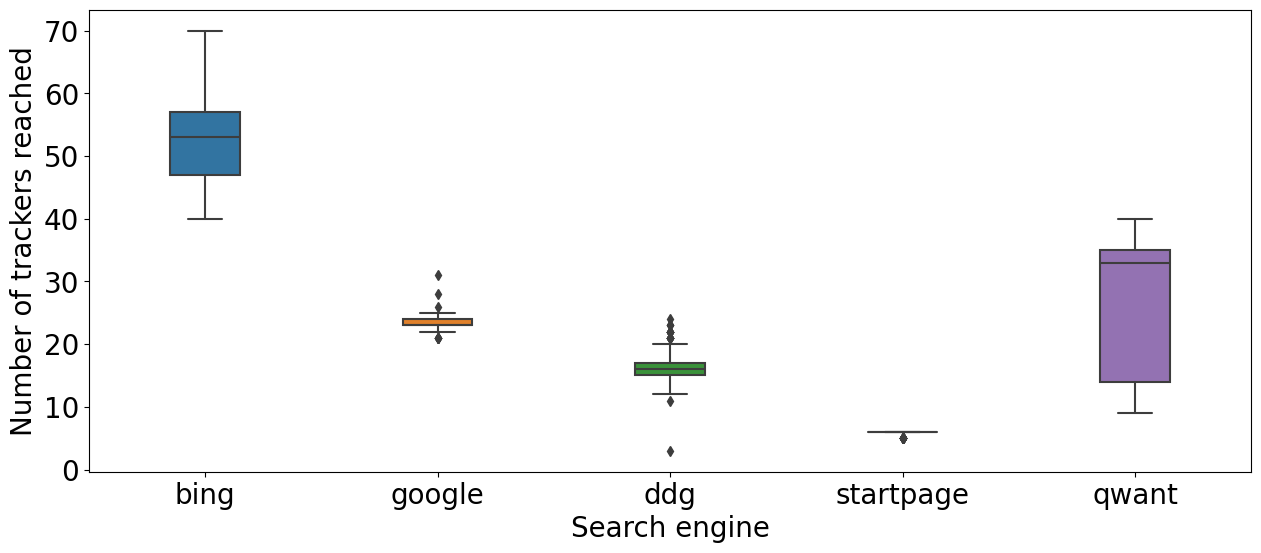

In [5]:
res = []

for index, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[index]
    
    for search in se_searches:
            
        res.append({"search_engine" : se, "number_of_trackers" : len(search["tracker_domains_before_clicking"])})

df = pd.DataFrame(res)

display_box_plot(df, "Search engine", "Number of trackers reached", width = 0.3, style = "whitegrid", x = "search_engine", y = "number_of_trackers")


### Number of different tracker first parties reached before clicking on ads

In [6]:
char = get_chart_of_first_parties_by_se(ALL_SE_RESULTS, "tracker_domains_before_clicking")

char.save('plots/number_of_different_tracker_parties_before_clicking_ad.pdf')

char

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Most common tracker first parties reached before clicking on ads

In [7]:
top_tracker_parties_before_clicking = get_top_parties_by_se(ALL_SE_RESULTS, "tracker_domains_before_clicking")

with open("tables/most_common_tracker_parties_before_clicking_ad.txt", "w") as text_file:
    text_file.write(top_tracker_parties_before_clicking.head(4).to_latex(index=False))

top_tracker_parties_before_clicking.head(5)

,Bing,Google,Ddg,Startpage,Qwant
0,www.bing.com (100.0%),www.google.com (82.7%),improving.duckduckgo.com (100.0%),www.startpage.com (100.0%),www.qwant.com (100.0%)
1,browser.pipe.aria.microsoft.com (0.0%),play.google.com (8.7%),,,
2,,id.google.com (4.3%),,,
3,,adservice.google.com (4.3%),,,
4,,,,,


### Number of parties by entities before clicking on ads

In [8]:
chart = get_chart_of_first_parties_by_entities(ALL_SE_RESULTS, "tracker_domains_before_clicking")

chart.save('plots/fraction_of_thirdparties_by_entites.pdf')

chart

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Iterations where a request to a tracker thirdparty was sent before clicking on an ad

In [9]:
for index, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[index]

    numbers_of_domains = [len(search["tracker_domains_before_clicking"]) for search in se_searches]
    
    df = pd.DataFrame({se: numbers_of_domains})
    
    if len(numbers_of_domains) == 0:
        continue

    fraction = len([item for item in numbers_of_domains if item > 0 ]) / len(numbers_of_domains)
    
    
    print(se, "Fraction of queries where a request was sent to a tracker thirdparty", fraction)
    print(df.describe())

    print()
        

bing Fraction of queries where a request was sent to a tracker thirdparty 1.0
             bing
count  375.000000
mean    52.322667
std      6.255683
min     40.000000
25%     47.000000
50%     53.000000
75%     57.000000
max     70.000000

google Fraction of queries where a request was sent to a tracker thirdparty 1.0
          google
count  53.000000
mean   23.377358
std     1.655137
min    21.000000
25%    23.000000
50%    23.000000
75%    24.000000
max    31.000000

ddg Fraction of queries where a request was sent to a tracker thirdparty 1.0
              ddg
count  500.000000
mean    16.076000
std      2.049054
min      3.000000
25%     15.000000
50%     16.000000
75%     17.000000
max     24.000000

startpage Fraction of queries where a request was sent to a tracker thirdparty 1.0
        startpage
count  500.000000
mean     5.954000
std      0.209695
min      5.000000
25%      6.000000
50%      6.000000
75%      6.000000
max      6.000000

qwant Fraction of queries where a reque

# 4. When clicking ads

### Extracting requests from search engines before clicking on an ad

In [10]:
for index, se_searches in enumerate(ALL_SE_RESULTS):
        
    for search in se_searches:
        
        first_party_key = list(search["requests_by_first_parties"][0].keys())[0]
              
        requests_after_clicking_from_search_engine = [item for item in search["requests_by_first_parties"][0][first_party_key]]
        domains_after_clicking_from_search_engine = [urlparse(item["url"]).netloc for item in requests_after_clicking_from_search_engine]
        tracker_requests_after_clicking_from_search_engine = [item for item in requests_after_clicking_from_search_engine if item["is_tracker"] is True]
        tracker_domains_after_clicking_from_search_engine = [urlparse(item["url"]).netloc for item in tracker_requests_after_clicking_from_search_engine]

        
        search["requests_after_clicking_from_search_engine"] = requests_after_clicking_from_search_engine
        search["domains_after_clicking_from_search_engine"] = domains_after_clicking_from_search_engine
        search["tracker_requests_after_clicking_from_search_engine"] = tracker_requests_after_clicking_from_search_engine
        search["tracker_domains_after_clicking_from_search_engine"] = tracker_domains_after_clicking_from_search_engine
    

### Number of different tracker domains reached from the search engine's page when clicking an ad

In [11]:
char = get_chart_of_first_parties_by_se(ALL_SE_RESULTS, "tracker_domains_after_clicking_from_search_engine")

char.save('plots/number_of_different_tracker_parties_after_clicking_ad_from_se.pdf')

char

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Most common domains reached by the search engine's pages when clicking on ads

In [12]:
top_tracker_parties_before_clicking = get_top_parties_by_se(ALL_SE_RESULTS, "domains_after_clicking_from_search_engine")

with open("tables/most_common_tracker_parties_after_clicking_ad_from_se.txt", "w") as text_file:
    text_file.write(top_tracker_parties_before_clicking.head(4).to_latex(index=False))

top_tracker_parties_before_clicking.head(5)


,Bing,Google,Ddg,Startpage,Qwant
0,www.bing.com (70.1%),www.google.com (58.8%),improving.duckduckgo.com (76.1%),www.google.com (99.8%),www.qwant.com (80.9%)
1,s.alicdn.com (8.0%),encrypted-tbn0.gstatic.com (34.0%),duckduckgo.com (23.9%),www.startpage.com (0.2%),www.bing.com (19.1%)
2,r.bing.com (5.2%),lh5.googleusercontent.com (5.4%),,,
3,gj.mmstat.com (3.7%),i.ytimg.com (1.2%),,,
4,i.alicdn.com (1.5%),ssl.gstatic.com (0.3%),,,


### Number of domains users bounce through when clicking ads (between search engine and destination URL)

In [13]:
keys = ALL_SE_NAMES
lists = [[len(search["redirectors"]) for search in se_searches if len(search["requests_after_reaching_destination"]) > 0] for se_searches in ALL_SE_RESULTS]

df = []

for index in range(len(keys)):
    
    counter = Counter(lists[index])
    counter = OrderedDict(sorted(counter.items()))
    total = sum(counter.values())
    
    for key, value in counter.items():
        if key == 1:
            df.append({"search_engine" : keys[index] , "number_of_first_parties" : str(key) + " Redirector", "Proportion of navigation paths" : 100 * (value/total)})

        else:
            df.append({"search_engine" : keys[index] , "number_of_first_parties" : str(key) + " Redirectors", "Proportion of navigation paths" : 100 * (value/total)})

df = pd.DataFrame(df)


chart = alt.Chart(df).mark_bar().encode(
#    x=alt.X('search_engine:O', axis=alt.Axis(title="",labels=False, ticks = False)),
    x=alt.X('search_engine:O', axis=alt.Axis(title="",labels=True, ticks = True)),
    y='Proportion of navigation paths:Q',
    color=alt.Color('search_engine:N', legend=None),
    column = alt.Column("number_of_first_parties:N", title=""),

)

#chart.save('plots/number_of_redirectors.pdf')

chart


/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

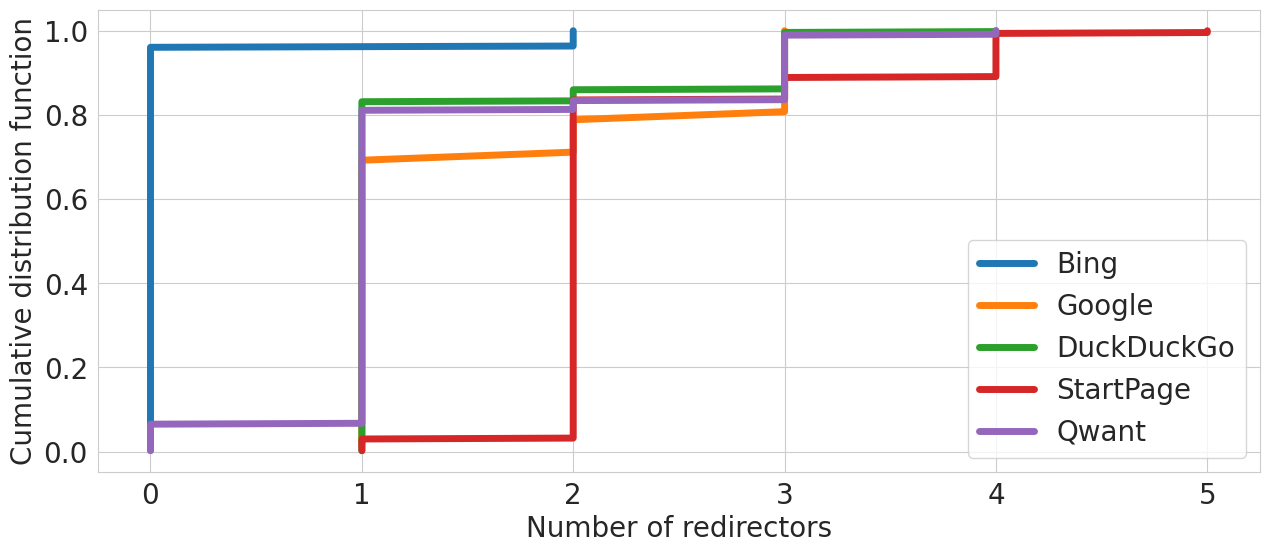

In [14]:
keys = ["Bing", "Google", "DuckDuckGo", "StartPage", "Qwant"]
plt = display_cdf(lists, keys, "", "Number of redirectors", scale = "linear", markers = ["", "", "", "", "", "", ""], colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], img_name="plots/number_of_redirectors_cdf.pdf")



### Top redirectors users bounce through for each search engine

In [15]:
top_redirectors = get_top_parties_by_se(ALL_SE_RESULTS, "redirectors")

with open("tables/most_common_redirectors.txt", "w") as text_file:
    text_file.write(top_redirectors.head(14).to_latex(index=False))

top_redirectors.head(10)

,Bing,Google,Ddg,Startpage,Qwant
0,clickserve.dartsearch.net (42.3%),www.googleadservices.com (65.8%),www.bing.com (76.0%),www.google.com (44.4%),www.bing.com (57.4%)
1,ad.doubleclick.net (42.3%),ad.doubleclick.net (13.9%),clickserve.dartsearch.net (10.8%),www.googleadservices.com (43.1%),ad.doubleclick.net (8.4%)
2,t23.intelliad.de (7.7%),clickserve.dartsearch.net (12.7%),ad.doubleclick.net (10.7%),clickserve.dartsearch.net (5.1%),clickserve.dartsearch.net (7.8%)
3,1045.netrk.net (7.7%),pixel.everesttech.net (2.5%),monitor.clickcease.com (0.8%),ad.doubleclick.net (4.9%),www.awin1.com (4.5%)
4,,monitor.clickcease.com (2.5%),6102.xg4ken.com (0.5%),monitor.clickcease.com (1.3%),tc.tradetracker.net (3.2%)
5,,monitor.ppcprotect.com (1.3%),pixel.everesttech.net (0.3%),6008.xg4ken.com (0.3%),adidas.prf.hn (3.1%)
6,,3825.xg4ken.com (1.3%),5350.xg4ken.com (0.3%),monitor.ppcprotect.com (0.2%),adidas.onelink.me (3.1%)
7,,,tpt.mediaplex.com (0.2%),3367.xg4ken.com (0.2%),track.effiliation.com (2.3%)
8,,,3367.xg4ken.com (0.2%),t.myvisualiq.net (0.1%),click.linksynergy.com (1.5%)
9,,,www.awin1.com (0.2%),ad.atdmt.com (0.1%),cj.dotomi.com (1.5%)


### Top navigation paths for each search engine

In [16]:
pd.set_option('display.max_colwidth', None)
navigation_paths_df_2 = []

paths_by_se = dict()

for index, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[index]
    paths_by_se[se] = [search["path"] for search in se_searches if search["path"] not in [""]]
    
    
    counter = Counter(paths_by_se[se])
    total = sum(counter.values())
    counter = {k: round(100 * (v/total), 1) for k, v in counter.items()} 
    counter = dict(sorted(counter.items(), key=lambda item: item[1], reverse = True))
    
    for k, v in counter.items():
        
        navigation_paths_df_2.append({"Search engine" : se.capitalize(), "Redirection chain" : k, "Frequency" : str(v)+"%"})

navigation_paths_df_2 = pd.DataFrame(navigation_paths_df_2)
navigation_paths_df_2


,Search engine,Redirection chain,Frequency
0,Bing,www.bing.com - destination,96.1%
1,Bing,www.bing.com - clickserve.dartsearch.net - ad.doubleclick.net - destination,3.3%
2,Bing,www.bing.com - t23.intelliad.de - 1045.netrk.net - destination,0.6%
3,Google,www.google.com - www.googleadservices.com - destination,69.2%
4,Google,www.google.com - www.googleadservices.com - clickserve.dartsearch.net - ad.doubleclick.net - destination,17.3%
...,...,...,...
57,Qwant,www.qwant.com - ww2.affinity.net - www.jdoqocy.com - cj.dotomi.com - cj.mplxtms.com - destination,0.2%
58,Qwant,www.qwant.com - qwant-fr.digidip.net - www.awin1.com - destination,0.2%
59,Qwant,www.qwant.com - c3po.link - destination,0.2%
60,Qwant,www.qwant.com - www.swagbucks.com - www.awin1.com - destination,0.2%


In [17]:
navigation_paths_by_entity = navigation_paths_df_2.copy()

distinct_entities_by_se = {"Bing": [], "Google": [], "Ddg": [], "Startpage": [], "Qwant": []}

for idx, row in navigation_paths_by_entity.iterrows():
    
    
    redirectors = row["Redirection chain"].split(" - ")
    entities_path = []
    
    
    for redirector in redirectors: 
        
        if redirector == "destination":
            entity = "destination"
            
        elif redirector == "duckduckgo.com":
            entity = "DuckDuckGo"
            
        elif redirector == "www.startpage.com":
            entity = "StartPage"
            
        elif redirector == "www.qwant.com":
            entity = "Qwant"
        
        else:
            etld = ".".join(redirector.split(".")[1:])
            entity = get_entity(etld)
            
        if entity == "":
            entity = "Unknown"
            
        entities_path.append(entity)
        
        distinct_entities_by_se[row["Search engine"]].append(entity)
        
    entities_path_unique = []
    
    for entity in entities_path:
        if entity not in entities_path_unique:
            entities_path_unique.append(entity)
   
    navigation_paths_by_entity.at[idx,'Redirection chain']= " - ".join(entities_path_unique)

#navigation_paths_by_entity
navigation_paths_by_entity.groupby('Redirection chain')['Frequency'].sum()


Redirection chain
DuckDuckGo - Microsoft - Adobe - destination                                                             0.4%
DuckDuckGo - Microsoft - Kenshoo - destination                                                   0.6%0.4%0.2%
DuckDuckGo - Microsoft - Unknown - Google - ConversantMedia - destination                                0.2%
DuckDuckGo - Microsoft - Unknown - Google - PPCProtect - destination                                     0.2%
DuckDuckGo - Microsoft - Unknown - Google - destination                                                 13.6%
DuckDuckGo - Microsoft - Unknown - destination                                                       1.0%0.2%
DuckDuckGo - Microsoft - destination                                                                    82.9%
DuckDuckGo - Unknown - destination                                                                       0.2%
Google - Adobe - destination                                                                          

### Do redirectors belong to the same first party as the search engines

In [18]:
keys = ALL_SE_NAMES

redirectors_by_positions = dict()
entities_by_se = dict()

for index, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[index]

    redirectors_by_positions[se] = dict()
    entities_by_se[se] = []
    
    for search in se_searches:
        first_parties = [list(item.keys()) for item in search["requests_by_first_parties"][1:-1]]
        first_parties = [item for sublist in first_parties for item in sublist]
        
        for idx, first_party in enumerate(first_parties):
            if idx not in  redirectors_by_positions[se]:
                redirectors_by_positions[se][idx] = []
                
            redirectors_by_positions[se][idx].append(first_party)
            
            entities_by_se[se].append(get_entity(".".join(first_party.split(".")[1:])))
            
        
df = []

for se, parties_by_positions in redirectors_by_positions.items():
    
    for position, parties in parties_by_positions.items():

        fraction_of_third_parties = len([item for item in parties if item != "www."+se+".com"]) /len(parties)
        df.append({"Search engine" : se, "Redirector position" : "Position " + str(position + 1), "Fraction of third parties" : fraction_of_third_parties})
        
        
        
df = pd.DataFrame(df)

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Search engine:O', axis=alt.Axis(title="",labels=True, ticks = True)),
    y='Fraction of third parties:Q',
    color=alt.Color('Search engine:N', legend=None),
    column = alt.Column("Redirector position:N", title=""),

)

chart.save('plots/fraction_of_third_parties_by_redirector_position.pdf')

chart


/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Entities of redirectors by search engines 

In [19]:
all_entities =[]

for a, b in entities_by_se.items():
    all_entities += b

all_entities = list(set(all_entities))
all_entities = [item for item in all_entities if item != ""]

df = []

for base in all_entities:
    for se, entities in entities_by_se.items():
        
        
        df.append({
            "Search engine" : se,
            "Entity" : base,
            "Fraction of redirectors" : 0 if len(entities)==0 else len([item for item in entities if item == base])/len(entities)
        })
        
df = pd.DataFrame(df)

chart = alt.Chart(df).mark_bar().encode(
    x=alt.X('Search engine:O', axis=alt.Axis(title="",labels=True, ticks = True)),
    y='Fraction of redirectors:Q',
    color=alt.Color('Search engine:N', legend=None),
    column = alt.Column("Entity:O", title="Entities"),

)

        
    
chart.save('plots/fraction_of_redirectors_by_entites.pdf')
chart


/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Number of iterations where the user bounced through a third-party tracker when clicking an ad

In [20]:
for index, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[index]

    numbers_of_domains = [len(search["tracker_domains_after_clicking"]) for search in se_searches]
    
    df = pd.DataFrame({se: numbers_of_domains})
    
    if len(numbers_of_domains) == 0:
        continue

    fraction = len([item for item in numbers_of_domains if item > 0 ]) / len(numbers_of_domains)
    
    print(se, "Fraction of queries where a request was sent to a tracker thirdparty", fraction)
    print(df.describe())

    print()
        

bing Fraction of queries where a request was sent to a tracker thirdparty 0.9093333333333333
             bing
count  375.000000
mean     4.674667
std     13.272978
min      0.000000
25%      1.000000
50%      1.000000
75%      2.000000
max    130.000000

google Fraction of queries where a request was sent to a tracker thirdparty 1.0
          google
count  53.000000
mean    4.000000
std     0.960769
min     2.000000
25%     3.000000
50%     4.000000
75%     5.000000
max     6.000000

ddg Fraction of queries where a request was sent to a tracker thirdparty 1.0
              ddg
count  500.000000
mean     3.238000
std      0.577948
min      1.000000
25%      3.000000
50%      3.000000
75%      3.000000
max      6.000000

startpage Fraction of queries where a request was sent to a tracker thirdparty 0.476
        startpage
count  500.000000
mean     1.464000
std      4.799456
min      0.000000
25%      0.000000
50%      0.000000
75%      1.000000
max     58.000000

qwant Fraction of quer

### Detect redirectors who always create cookies, and redirectors who do not 

In [21]:
redirectors_creating_cookies_by_se = dict()
redirectors_not_creating_cookies_by_se = dict()
number_of_redirectors_creating_cookies_by_se = dict()

for se, se_searches in enumerate(ALL_SE_RESULTS):
    
    se = ALL_SE_NAMES[se]
    redirectors_creating_cookies_by_se[se] = []
    redirectors_not_creating_cookies_by_se[se] = []
    number_of_redirectors_creating_cookies_by_se[se] = []

    for idx, search in enumerate(se_searches):
        
        redirectors_creating_cookies_by_se[se].append([])

        all_redirectors = search["redirectors"]
        redirectors_creating_cookies = [item[1] for item in search["set-cookies_after_clicking"]]
        
        if se == "bing":
            redirectors_creating_cookies = [item for item in redirectors_creating_cookies if item != "www.bing"]
            
        elif se == "google":
            redirectors_creating_cookies = [item for item in redirectors_creating_cookies if item != "www.google"]

        number_of_redirectors_creating_cookies_by_se[se].append(len(set(redirectors_creating_cookies)))
        
        for redirector in all_redirectors:
            if list(set([redirector, redirector[:-4], redirector[:-3]]) & set(redirectors_creating_cookies)) == []:
                redirectors_not_creating_cookies_by_se[se].append(redirector)
                
            else:
#                redirectors_creating_cookies_by_se[se].append(redirector)
                 
                redirectors_creating_cookies_by_se[se][idx].append(redirector)

#    redirectors_not_creating_cookies_by_se[se] = list(set(redirectors_not_creating_cookies_by_se[se]))
#    redirectors_creating_cookies_by_se[se] = list(set(redirectors_creating_cookies_by_se[se]))
    
    

### Number of redirectors who store uids 

In [22]:
keys = ["Bing", "Google", "DuckDuckGo", "Startpage", "Qwant"]
lists = [number_of_redirectors_creating_cookies_by_se[key] for key in number_of_redirectors_creating_cookies_by_se]

df = []

for index in range(len(keys)):
    
    counter = Counter(lists[index])
    counter = OrderedDict(sorted(counter.items()))
    total = sum(counter.values())
    
    for key, value in counter.items():
        if key == 1:
            df.append({"search_engine" : keys[index] , "number_of_first_parties" : str(key) + " Redirector", "Proportion of navigation paths" : 100 * (value/total)})

        else:
            df.append({"search_engine" : keys[index] , "number_of_first_parties" : str(key) + " Redirectors", "Proportion of navigation paths" : 100 * (value/total)})

df = pd.DataFrame(df)


chart = alt.Chart(df).mark_bar().encode(
#    x=alt.X('search_engine:O', axis=alt.Axis(title="",labels=False, ticks = False)),
    x=alt.X('search_engine:O', axis=alt.Axis(title="",labels=True, ticks = True)),
    y='Proportion of navigation paths:Q',
    color=alt.Color('search_engine:N', legend=None),
    column = alt.Column("number_of_first_parties:N", title=""),

)

#chart.save('plots/number_of_redirectors.pdf')

chart


 

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Number of redirectors who store uids 

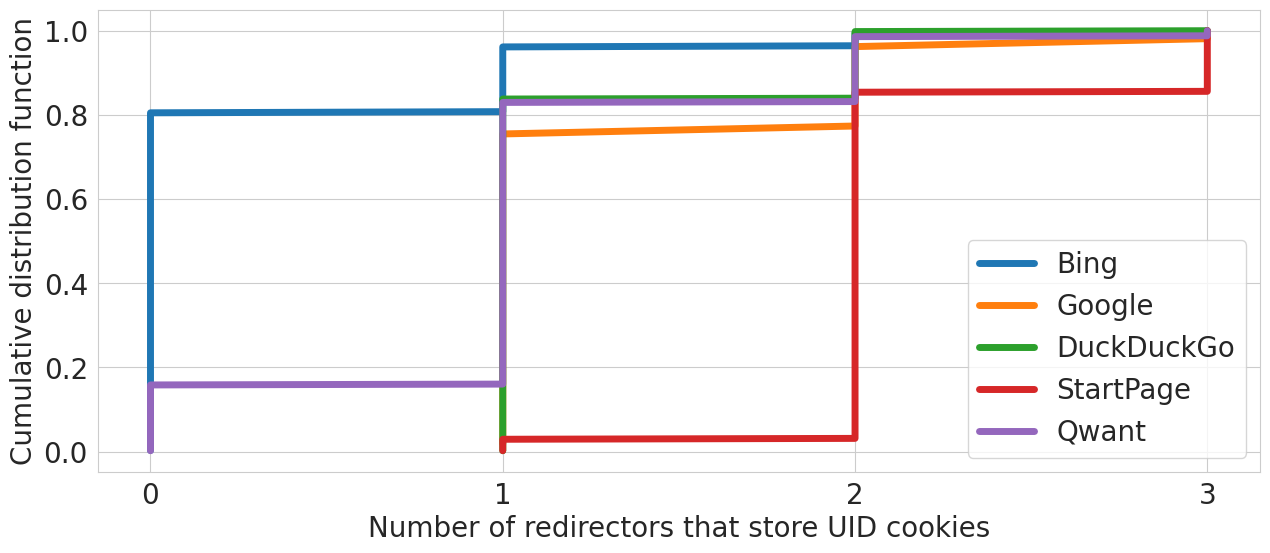

In [23]:
keys = ["Bing", "Google", "DuckDuckGo", "StartPage", "Qwant"]
lists = [[item for item in number_of_redirectors_creating_cookies_by_se[key] if item <=3] for key in number_of_redirectors_creating_cookies_by_se]
plt = display_cdf(lists, keys, "", "Number of redirectors that store UID cookies", scale = "linear", markers = ["", "", "", "", "", "", ""], colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"], img_name="plots/number_of_redirectors_storing_uid.pdf", x_ticks=[0,1,2,3])



### Who are the redirectors who create cookies

In [24]:
different_redirectors_creating_cookies_by_se = dict()
    
for se, values in redirectors_creating_cookies_by_se.items():
    
    values = list(set([item for sublist in values for item in sublist]))
    different_redirectors_creating_cookies_by_se[se] = values


In [25]:
df_creating_cookies = []

for se, values in different_redirectors_creating_cookies_by_se.items():
    
    intersection = list(set(values) & set(redirectors_not_creating_cookies_by_se[se]))
    
    
    for redirector in values:
        number_of_paths_with_redirector = len([list_ for list_ in redirectors_creating_cookies_by_se[se] if redirector in list_])
        
        df_creating_cookies += [{"se":se, "redirector":redirector, "fraction" : number_of_paths_with_redirector/len(redirectors_creating_cookies_by_se[se]) }]
        
    
pd.DataFrame(df_creating_cookies)

,se,redirector,fraction
0,bing,1045.netrk.net,0.005333
1,bing,ad.doubleclick.net,0.029333
2,bing,t23.intelliad.de,0.005333
3,google,pixel.everesttech.net,0.037736
4,google,monitor.ppcprotect.com,0.018868
5,google,3825.xg4ken.com,0.018868
6,google,ad.doubleclick.net,0.207547
7,google,www.googleadservices.com,0.981132
8,ddg,pixel.everesttech.net,0.004000
9,ddg,3367.xg4ken.com,0.002000


# 5. After clicking on ads

### Number of different destination websites

In [26]:
for se, se_results in enumerate(ALL_SE_RESULTS):
    destination_web_sites = []
    for result in se_results:
        destination_web_sites += [list(item.keys()) for item in result["requests_by_first_parties"]][-1:][0][0]    
    print("SE : ", ALL_SE_NAMES[se], "Number of different websites : ", len(set(destination_web_sites))) 

SE :  bing Number of different websites :  41
SE :  google Number of different websites :  29
SE :  ddg Number of different websites :  34
SE :  startpage Number of different websites :  41
SE :  qwant Number of different websites :  37


### Number of different trackers reached from destination pages

In [27]:
char = get_chart_of_first_parties_by_se(ALL_SE_RESULTS, "tracker_domains_after_reaching_destination")

char.save('plots/number_of_different_tracker_parties_after_reaching_destination.pdf')

char

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
WARN Symbol legend count exceeds limit, filtering items.
/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Most common trackers reached from destination pages

In [28]:
top_tracker_parties_before_clicking = get_top_parties_by_se(ALL_SE_RESULTS, "tracker_domains_after_reaching_destination")

with open("tables/most_common_tracker_parties_after_reaching_destination.txt", "w") as text_file:
    text_file.write(top_tracker_parties_before_clicking.head(4).to_latex(index=False))

top_tracker_parties_before_clicking


,Bing,Google,Ddg,Startpage,Qwant
0,fls-eu.amazon.fr (6.9%),www.google.com (6.4%),fls-eu.amazon.fr (15.3%),www.google-analytics.com (11.0%),fls-eu.amazon.fr (18.9%)
1,www.bing.com (6.2%),www.google-analytics.com (5.5%),www.googletagmanager.com (5.9%),www.googletagmanager.com (8.4%),www.googletagmanager.com (6.6%)
2,www.googletagmanager.com (6.0%),www.googletagmanager.com (4.9%),fls-na.amazon.com (4.8%),www.google.com (4.9%),www.google-analytics.com (4.6%)
3,www.google-analytics.com (5.0%),bat.bing.com (4.5%),bat.bing.com (3.7%),analytics.tiktok.com (4.7%),www.amazon.fr (3.9%)
4,bat.bing.com (4.8%),analytics.tiktok.com (4.2%),www.google-analytics.com (3.6%),www.google.fr (4.1%),unagi.amazon.fr (3.2%)
...,...,...,...,...,...
10439,,<NA>,,,
10440,,<NA>,,,
10441,,<NA>,,,
10442,,<NA>,,,


### Iterations where a request was sent to a tracker thirdparty from the destination page

In [29]:
for se, results in enumerate(ALL_SE_RESULTS):
    different_trackers_numbers= []
    different_trackers = []
    for result in results:
        different_trackers_numbers.append(len(set(result["tracker_domains_after_reaching_destination"])))
        different_trackers += list(set(result["tracker_domains_after_reaching_destination"]))
        
    print("SE : ", ALL_SE_NAMES[se])
    print("fraction of queries where a request was sent to thirdparties : ", len([item for item in different_trackers_numbers if item > 0]) / len(different_trackers_numbers))
    print("different trackers overall:", len(set(different_trackers)))
    print("median different trackers per iteration:", np.median(different_trackers_numbers))
    print()

SE :  bing
fraction of queries where a request was sent to thirdparties :  0.8746666666666667
different trackers overall: 444
median different trackers per iteration: 6.0

SE :  google
fraction of queries where a request was sent to thirdparties :  0.9811320754716981
different trackers overall: 218
median different trackers per iteration: 11.0

SE :  ddg
fraction of queries where a request was sent to thirdparties :  0.962
different trackers overall: 561
median different trackers per iteration: 5.0

SE :  startpage
fraction of queries where a request was sent to thirdparties :  0.902
different trackers overall: 622
median different trackers per iteration: 7.0

SE :  qwant
fraction of queries where a request was sent to thirdparties :  0.936
different trackers overall: 448
median different trackers per iteration: 5.0



### Entities of trackers reached from destination pages

In [30]:
chart = get_chart_of_first_parties_by_entities(ALL_SE_RESULTS, "tracker_domains_after_reaching_destination")
chart

/home/slide/chouakis/virtual_envs/jupyter_env/lib/python3.9/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.Chart(...)

### Most common entities reached from destination pages

In [31]:
top_entityes = get_top_parties_by_entities(ALL_SE_RESULTS, "tracker_domains_after_reaching_destination")
print("Number of different entities for Bing", len([item for item in top_entityes["Bing"].to_list() if item!= ""]))
print("Number of different entities for Google", len([item for item in top_entityes["Google"].to_list() if str(item) not in ["", "<NA>"]]))
print("Number of different entities for Ddg", len([item for item in top_entityes["Ddg"].to_list() if item!= ""]))
print("Number of different entities for Startpage", len([item for item in top_entityes["Startpage"].to_list() if item!= ""]))
print("Number of different entities for Qwant", len([item for item in top_entityes["Qwant"].to_list() if str(item) not in ["", "<NA>"]]))

top_entityes.head(10)


Number of different entities for Bing 75
Number of different entities for Google 55
Number of different entities for Ddg 99
Number of different entities for Startpage 103
Number of different entities for Qwant 72


,Bing,Google,Ddg,Startpage,Qwant
0,(32.0%),(34.8%),Amazon.com (30.6%),(32.3%),Amazon.com (29.9%)
1,Google (18.9%),Google (28.7%),(26.4%),Google (32.2%),(26.9%)
2,Microsoft (15.9%),Microsoft (10.5%),Google (13.5%),Microsoft (7.3%),Google (18.3%)
3,Amazon.com (11.7%),Facebook (3.5%),Microsoft (7.6%),Facebook (5.1%),Microsoft (5.7%)
4,Facebook (4.9%),Amazon.com (3.1%),Facebook (3.0%),Amazon.com (2.1%),Facebook (2.8%)
5,Pinterest (1.8%),Criteo (2.5%),Pinterest (1.7%),Criteo (1.9%),adscale (2.1%)
6,Criteo (1.6%),Bouncex (2.1%),Taboola (1.4%),Pinterest (1.8%),Criteo (1.8%)
7,Taboola (1.1%),Signifyd (1.9%),Adobe (1.1%),New Relic (1.3%),Adobe (1.7%)
8,Adobe (0.8%),HubSpot (1.5%),Criteo (1.1%),Taboola (1.2%),Taboola (1.2%)
9,AT Internet (0.7%),Pinterest (1.1%),Casale Media (1.0%),AT&T (1.0%),Akamai (0.8%)
